In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch torchvision timm pycocotools matplotlib


In [4]:
import os
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
from enet_sad import ENet_SAD

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [7]:
class LaneSegDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [f for f in os.listdir(folder) if f.endswith(".jpg")
                       and os.path.exists(os.path.join(folder, f.replace(".jpg",".png")))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.folder, img_name)
        mask_path = os.path.join(self.folder, img_name.replace(".jpg",".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)

        mask = transforms.ToTensor()(mask)
        mask = (mask > 0.5).long().squeeze(0)
        return image, mask

In [8]:
train_folder = "/content/drive/MyDrive/Lane_detection_dataset/train"
valid_folder = "/content/drive/MyDrive/Lane_detection_dataset/valid"

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = LaneSegDataset(train_folder, transform)
valid_dataset = LaneSegDataset(valid_folder, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

In [10]:
model = ENet_SAD(backbone='enet', sad=True, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 25

Epoch 25/25 | Train Loss: 0.1031 | Val Loss: 0.1107


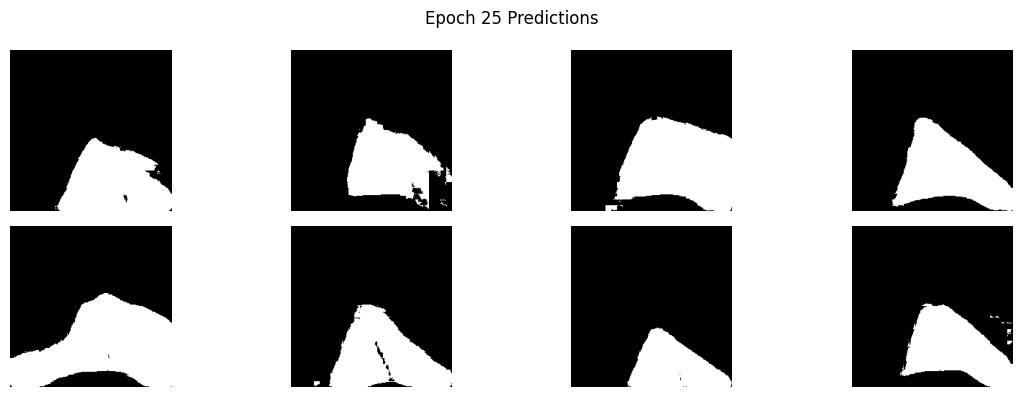

In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in valid_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, masks).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(valid_loader):.4f}")


    imgs_cpu = imgs.cpu()
    preds_cpu = torch.argmax(outputs, dim=1).cpu()
    batch_size = min(8, imgs_cpu.size(0))
    fig, axes = plt.subplots(2, batch_size//2, figsize=(12,4))
    axes = axes.flatten()
    for i in range(batch_size):
        axes[i].imshow(preds_cpu[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Epoch {epoch+1} Predictions")
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)

    torch.save(model.state_dict(), f"/content/drive/MyDrive/Lane_detection_dataset/enet_sad_lane{epoch+1}.pth")

✅ Video saved at: /content/output_overlay1.mp4


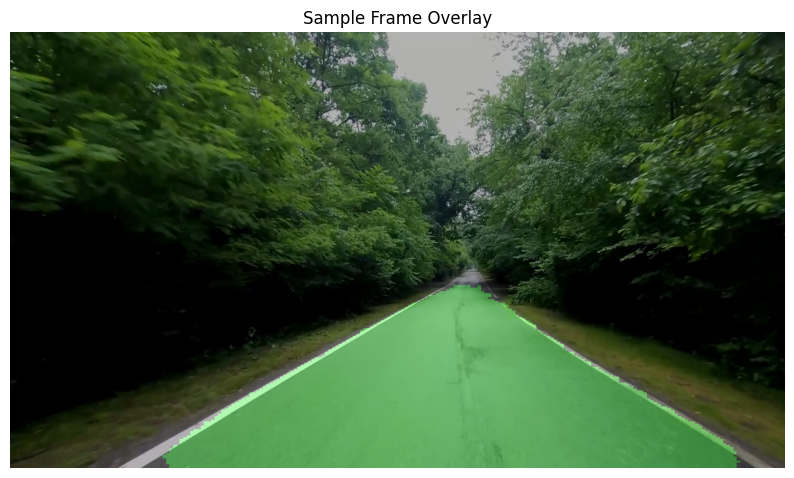

In [ ]:

!pip install torch torchvision opencv-python matplotlib


import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from enet_sad import ENet_SAD


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = ENet_SAD(num_classes=num_classes).to(device)


checkpoint_path = "/content/drive/MyDrive/Lane_detection_dataset/enet_sad_lane25.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()


image_size = (224,224) 
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def overlay_lane(image_pil, pred_mask):
    img_np = np.array(image_pil)
    color_mask = np.zeros_like(img_np)
    color_mask[pred_mask==1] = [0, 255, 0]  
    overlay = cv2.addWeighted(img_np, 0.7, color_mask, 0.3, 0)
    return overlay

video_path = "/content/road_v.mp4"
output_path = "/content/output_overlay1.mp4"

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width,height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(frame_pil).unsqueeze(0).to(device)


    with torch.no_grad():
        pred = model(input_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()

    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), (width,height), interpolation=cv2.INTER_NEAREST)

    overlay_frame = overlay_lane(frame_pil, pred_mask_resized)

 
    out.write(cv2.cvtColor(overlay_frame, cv2.COLOR_RGB2BGR))

cap.release()
out.release()
print("✅ Video saved at:", output_path)


plt.figure(figsize=(10,6))
plt.imshow(overlay_frame)
plt.axis("off")
plt.title("Sample Frame Overlay")
plt.show()
